# Ejemplo: Detectando cáncer de mama maligno

[![](https://colab.research.google.com/assets/colab-badge.svg)](http://colab.research.google.com/github/ganegroup/workshop_nn/blob/main/04_breast_cancer.ipynb)

EL siguiente ejemplo es muy parecido al caso anterior, pero con un dataset más sencillo, en el que nuestro modelo lineal con sigmoide va a funcionar mejor

In [1]:
import tensorflow as tf
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import sklearn.metrics as sk_metrics
import tempfile
import os

# # Preset matplotlib figure sizes.
# matplotlib.rcParams['figure.figsize'] = [9, 6]

# print(tf.__version__)
# # To make the results reproducible, set the random seed value.
# tf.random.set_seed(22)

2023-07-02 14:20:07.647467: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
tf.config.list_physical_devices()


2023-07-02 14:20:09.238975: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-02 14:20:09.242358: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-02 14:20:09.242520: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Como en este caso los datos no están en `TFDS`, los vamos a tener que preparar manualmente

In [3]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data'

features = ['radius', 'texture', 'perimeter', 'area', 'smoothness', 'compactness',
            'concavity', 'concave_poinits', 'symmetry', 'fractal_dimension']
column_names = ['id', 'diagnosis']

for attr in ['mean', 'ste', 'largest']:
  for feature in features:
    column_names.append(feature + "_" + attr)

In [4]:
dataset = pd.read_csv(url, names=column_names)

In [5]:
dataset.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         569 non-null    int64  
 1   diagnosis                  569 non-null    object 
 2   radius_mean                569 non-null    float64
 3   texture_mean               569 non-null    float64
 4   perimeter_mean             569 non-null    float64
 5   area_mean                  569 non-null    float64
 6   smoothness_mean            569 non-null    float64
 7   compactness_mean           569 non-null    float64
 8   concavity_mean             569 non-null    float64
 9   concave_poinits_mean       569 non-null    float64
 10  symmetry_mean              569 non-null    float64
 11  fractal_dimension_mean     569 non-null    float64
 12  radius_ste                 569 non-null    float64
 13  texture_ste                569 non-null    float64

In [6]:
dataset.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_poinits_mean,...,radius_largest,texture_largest,perimeter_largest,area_largest,smoothness_largest,compactness_largest,concavity_largest,concave_poinits_largest,symmetry_largest,fractal_dimension_largest
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


Sampleamos una fracción del 75% para nuestro dataset de entrenamiento

In [7]:
train_dataset = dataset.sample(frac=0.75, random_state=1)

In [8]:
test_dataset = dataset.drop(train_dataset.index)

In [9]:
x_train, y_train = train_dataset.iloc[:, 2:], train_dataset.iloc[:, 1]
x_test, y_test = test_dataset.iloc[:, 2:], test_dataset.iloc[:, 1]

In [10]:
y_train, y_test = y_train.map({'B': 0, 'M': 1}), y_test.map({'B': 0, 'M': 1})
x_train, y_train = tf.convert_to_tensor(x_train, dtype=tf.float32), tf.convert_to_tensor(y_train, dtype=tf.float32)
x_test, y_test = tf.convert_to_tensor(x_test, dtype=tf.float32), tf.convert_to_tensor(y_test, dtype=tf.float32)

2023-07-02 14:20:11.489891: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-02 14:20:11.490179: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-02 14:20:11.490373: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

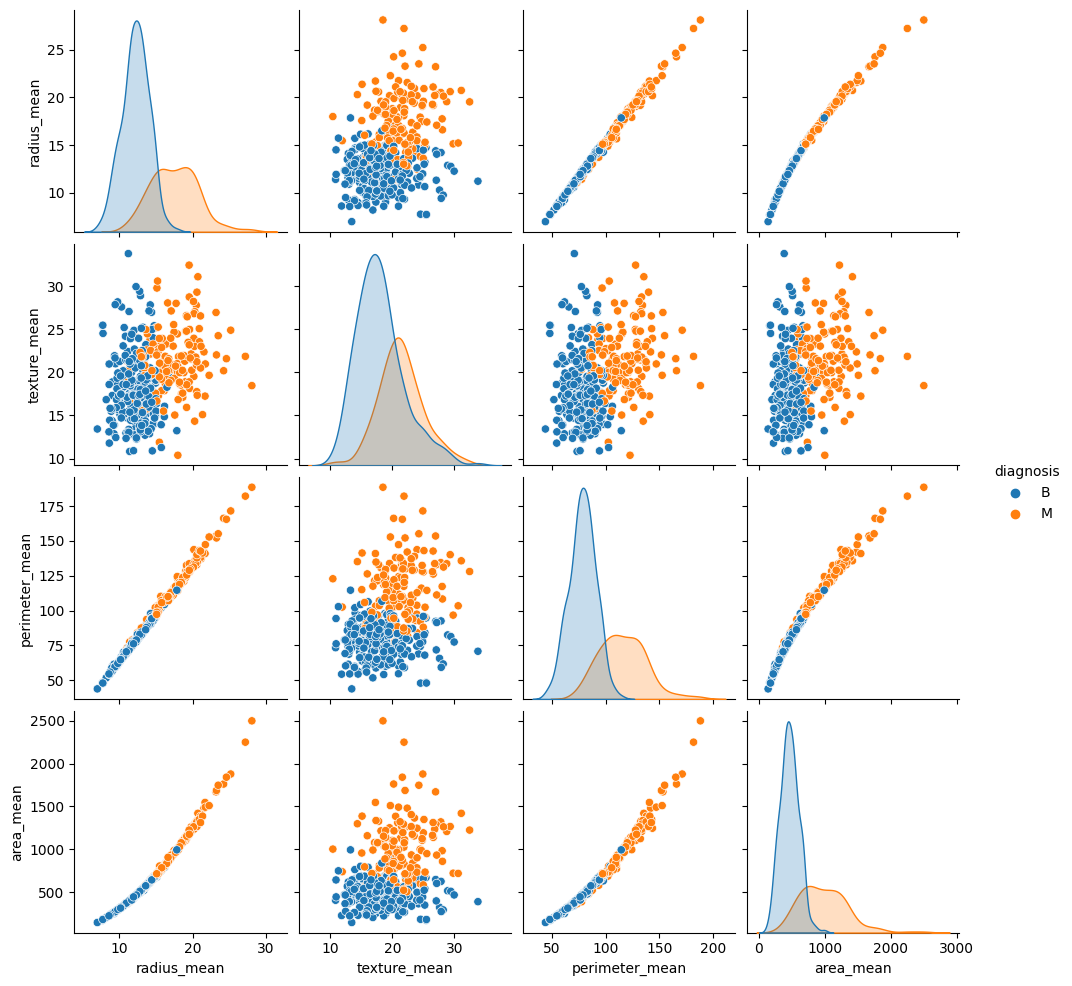

In [11]:
sns.pairplot(train_dataset.iloc[:, 1:6], hue = 'diagnosis', diag_kind='kde');

In [12]:
train_dataset.describe().transpose()[:10]


,count,mean,std,min,25%,50%,75%,max
id,427.0,2.756014e+07,1.162735e+08,8670.00000,865427.500000,905539.00000,8.810829e+06,9.113205e+08
radius_mean,427.0,1.414331e+01,3.528717e+00,6.98100,11.695000,13.43000,1.594000e+01,2.811000e+01
texture_mean,427.0,1.924468e+01,4.113131e+00,10.38000,16.330000,18.84000,2.168000e+01,3.381000e+01
perimeter_mean,427.0,9.206759e+01,2.431431e+01,43.79000,75.235000,86.87000,1.060000e+02,1.885000e+02
area_mean,427.0,6.563190e+02,3.489106e+02,143.50000,420.050000,553.50000,7.908500e+02,2.499000e+03
smoothness_mean,427.0,9.633618e-02,1.436820e-02,0.05263,0.085850,0.09566,1.050000e-01,1.634000e-01
compactness_mean,427.0,1.036597e-01,5.351893e-02,0.02344,0.063515,0.09182,1.296500e-01,3.454000e-01
concavity_mean,427.0,8.833008e-02,7.965884e-02,0.00000,0.029570,0.05999,1.297500e-01,4.268000e-01
concave_poinits_mean,427.0,4.872688e-02,3.853594e-02,0.00000,0.019650,0.03390,7.409500e-02,2.012000e-01
symmetry_mean,427.0,1.804597e-01,2.637837e-02,0.12030,0.161700,0.17840,1.947000e-01,2.906000e-01


In [13]:
class Normalize(tf.Module):
  def __init__(self, x):
    # Initialize the mean and standard deviation for normalization
    self.mean = tf.Variable(tf.math.reduce_mean(x, axis=0))
    self.std = tf.Variable(tf.math.reduce_std(x, axis=0))

  def norm(self, x):
    # Normalize the input
    return (x - self.mean)/self.std

  def unnorm(self, x):
    # Unnormalize the input
    return (x * self.std) + self.mean

norm_x = Normalize(x_train)
x_train_norm, x_test_norm = norm_x.norm(x_train), norm_x.norm(x_test)

In [14]:
def log_loss(y_pred, y):
  # Compute the log loss function
  ce = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=y_pred)
  return tf.reduce_mean(ce)

In [15]:
class LogisticRegression(tf.Module):

  def __init__(self):
    self.built = False

  def __call__(self, x, train=True):
    # Initialize the model parameters on the first call
    if not self.built:
      # Randomly generate the weights and the bias term
      rand_w = tf.random.uniform(shape=[x.shape[-1], 1], seed=22)
      rand_b = tf.random.uniform(shape=[], seed=22)
      self.w = tf.Variable(rand_w)
      self.b = tf.Variable(rand_b)
      self.built = True
    # Compute the model output
    z = tf.add(tf.matmul(x, self.w), self.b)
    z = tf.squeeze(z, axis=1)
    if train:
      return z
    return tf.sigmoid(z)

In [16]:
log_reg = LogisticRegression()

In [17]:
y_pred = log_reg(x_train_norm[:5], train=False)
y_pred.numpy()

array([0.9990741 , 0.9865949 , 0.03465715, 0.10381243, 0.4773758 ],
      dtype=float32)

In [18]:
def predict_class(y_pred, thresh=0.5):
  # Return a tensor with  `1` if `y_pred` > `0.5`, and `0` otherwise
  return tf.cast(y_pred > thresh, tf.float32)

def accuracy(y_pred, y):
  # Return the proportion of matches between `y_pred` and `y`
  y_pred = tf.math.sigmoid(y_pred)
  y_pred_class = predict_class(y_pred)
  check_equal = tf.cast(y_pred_class == y,tf.float32)
  acc_val = tf.reduce_mean(check_equal)
  return acc_val

In [19]:
batch_size = 64
train_dataset = tf.data.Dataset.from_tensor_slices((x_train_norm, y_train))
train_dataset = train_dataset.shuffle(buffer_size=x_train.shape[0]).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test_norm, y_test))
test_dataset = test_dataset.shuffle(buffer_size=x_test.shape[0]).batch(batch_size)

In [20]:
# Set training parameters
epochs = 200
learning_rate = 0.01
train_losses, test_losses = [], []
train_accs, test_accs = [], []

# Set up the training loop and begin training
for epoch in range(epochs):
  batch_losses_train, batch_accs_train = [], []
  batch_losses_test, batch_accs_test = [], []

  # Iterate over the training data
  for x_batch, y_batch in train_dataset:
    with tf.GradientTape() as tape:
      y_pred_batch = log_reg(x_batch)
      batch_loss = log_loss(y_pred_batch, y_batch)
    batch_acc = accuracy(y_pred_batch, y_batch)
    # Update the parameters with respect to the gradient calculations
    grads = tape.gradient(batch_loss, log_reg.variables)
    for g,v in zip(grads, log_reg.variables):
      v.assign_sub(learning_rate * g)
    # Keep track of batch-level training performance
    batch_losses_train.append(batch_loss)
    batch_accs_train.append(batch_acc)

  # Iterate over the testing data
  for x_batch, y_batch in test_dataset:
    y_pred_batch = log_reg(x_batch)
    batch_loss = log_loss(y_pred_batch, y_batch)
    batch_acc = accuracy(y_pred_batch, y_batch)
    # Keep track of batch-level testing performance
    batch_losses_test.append(batch_loss)
    batch_accs_test.append(batch_acc)

  # Keep track of epoch-level model performance
  train_loss, train_acc = tf.reduce_mean(batch_losses_train), tf.reduce_mean(batch_accs_train)
  test_loss, test_acc = tf.reduce_mean(batch_losses_test), tf.reduce_mean(batch_accs_test)
  train_losses.append(train_loss)
  train_accs.append(train_acc)
  test_losses.append(test_loss)
  test_accs.append(test_acc)
  if epoch % 20 == 0:
    print(f"Epoch: {epoch}, Training log loss: {train_loss:.3f}")

2023-07-02 14:20:15.771980: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [427,30]
	 [[{{node Placeholder/_0}}]]
2023-07-02 14:20:15.772198: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [427]
	 [[{{node Placeholder/_1}}]]
2023-07-02 14:20:15.888211: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [142]
	

Epoch: 0, Training log loss: 0.602
Epoch: 20, Training log loss: 0.400
Epoch: 40, Training log loss: 0.293
Epoch: 60, Training log loss: 0.203
Epoch: 80, Training log loss: 0.152
Epoch: 100, Training log loss: 0.122
Epoch: 120, Training log loss: 0.107
Epoch: 140, Training log loss: 0.095
Epoch: 160, Training log loss: 0.088
Epoch: 180, Training log loss: 0.084


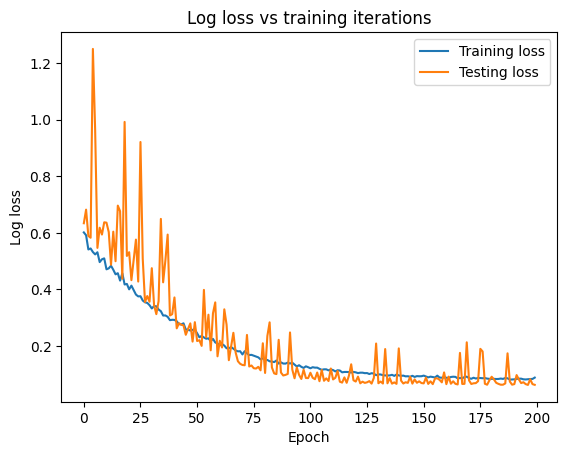

In [21]:
plt.plot(range(epochs), train_losses, label = "Training loss")
plt.plot(range(epochs), test_losses, label = "Testing loss")
plt.xlabel("Epoch")
plt.ylabel("Log loss")
plt.legend()
plt.title("Log loss vs training iterations");

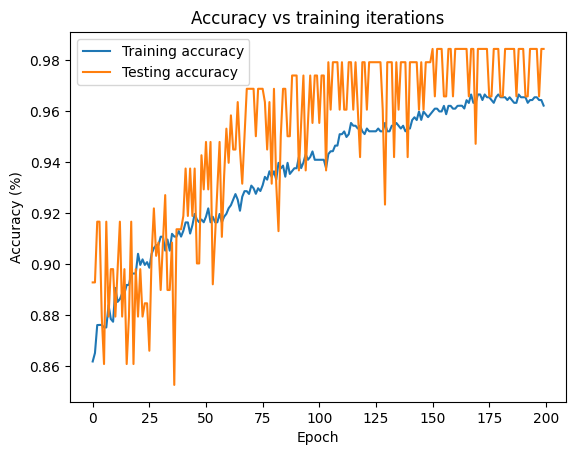

In [22]:
plt.plot(range(epochs), train_accs, label = "Training accuracy")
plt.plot(range(epochs), test_accs, label = "Testing accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.title("Accuracy vs training iterations");

In [23]:
def show_confusion_matrix(y, y_classes, typ, normalized=True):
  # Compute the confusion matrix and normalize it
  plt.figure(figsize=(10,10))
  confusion = sk_metrics.confusion_matrix(y.numpy(), y_classes.numpy())

  if normalized:
    confusion_normalized = confusion / confusion.sum(axis=1)
  else: 
    confusion_normalized = confusion

  axis_labels = range(2)
  ax = sns.heatmap(
      confusion_normalized, xticklabels=axis_labels, yticklabels=axis_labels,
      cmap='Blues', annot=True, fmt='.4f', square=True)
  plt.title(f"Confusion matrix: {typ}")
  plt.ylabel("True label")
  plt.xlabel("Predicted label")

  return confusion_normalized

y_pred_train, y_pred_test = log_reg(x_train_norm, train=False), log_reg(x_test_norm, train=False)
train_classes, test_classes = predict_class(y_pred_train), predict_class(y_pred_test)

![](https://static.packt-cdn.com/products/9781838555078/graphics/C13314_06_05.jpg)

- True negative (TN) El modelo predijo correctamente que era benigno
- True positives (TP) El modelo predijo correctamente que era maligno
- False positve (FP) El modelo predijo inccorrectamente que era maligno (Error tipo I)
- False negative (FN) El modelo predijo inccorrectamente que era benigno (Error tipo II)

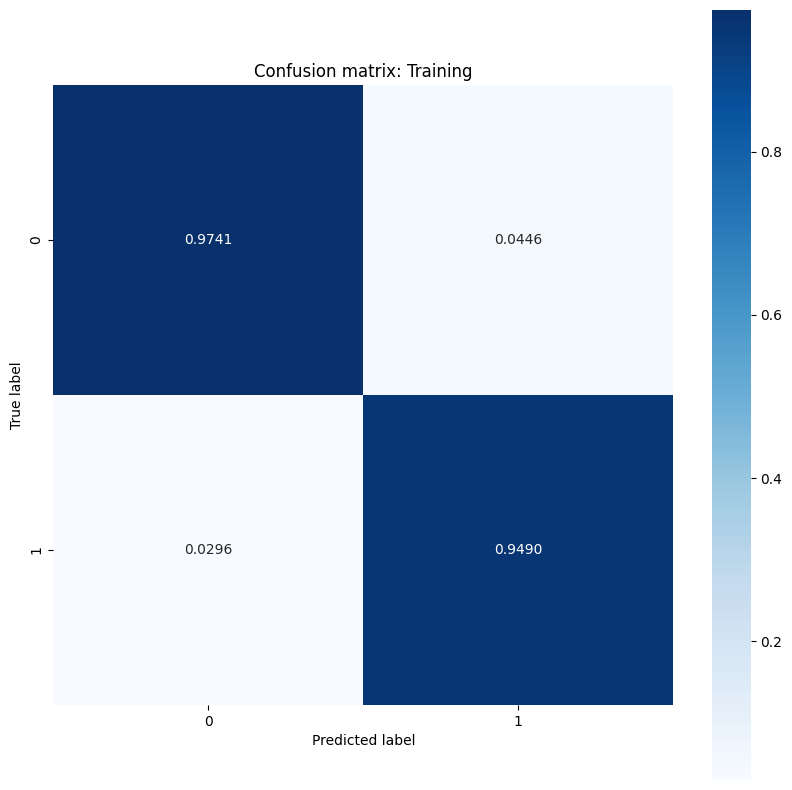

In [24]:
train_conf = show_confusion_matrix(y_train, train_classes, 'Training', normalized=True)


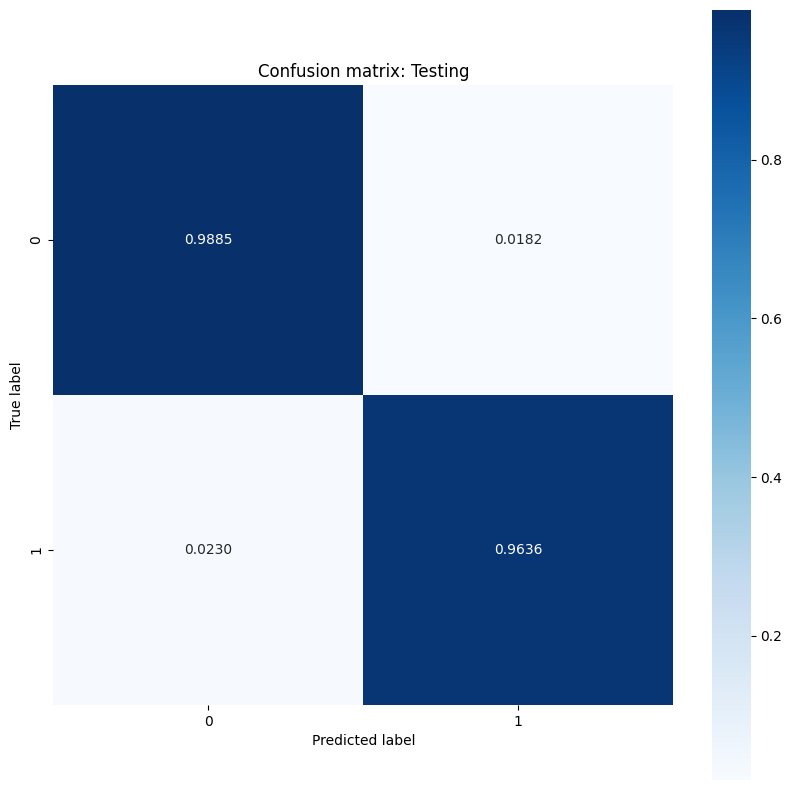

In [25]:
test_conf = show_confusion_matrix(y_test, test_classes, 'Testing')


### Otras métricas importantes 

**Recall (sensitivity)**

$$recall = \frac{TP} {TP + FN} = TPR $$ 


Recall intenta responder: ¿que proporción de positivos fue correctamente indentificados?

También se lo conoce como True Positive Rate (TPR)


In [26]:
from sklearn.metrics import recall_score

recall_score(y_train, train_classes)

0.9490445859872612

**Precision** 

$$ precision = \frac{TP} {TP + FP}$$

Precision intenta responder: ¿qué proporción de predicciones positivas fue realmente correcta?

In [27]:
from sklearn.metrics import precision_score

precision_score(y_train, train_classes)

0.9551282051282052

**False Positive Rate (FPR)**

$$ FPR = \frac{FP}{FP + TN} $$

Nos indica que tan predispuesto es el modelo a las falsas alarmas

## Curva ROC (Receiver Operating Characteristic)

La curva ROC compara el TPR con el FPR para distintos thresholds e ilustra el nivel de compromiso que existe entre los verdaderos positivos y los falsos positivos para determinado modelo

![](https://glassboxmedicine.files.wordpress.com/2019/02/roc-curve-v2.png)

In [28]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, y_pred_test)
    

In [29]:
thresholds

array([          inf, 1.0000000e+00, 9.9999857e-01, 9.9999797e-01,
       6.2926358e-01, 2.6216409e-01, 2.5385386e-01, 3.0328699e-03,
       2.7826922e-03, 3.0395117e-06], dtype=float32)

Text(0, 0.5, 'TPR')

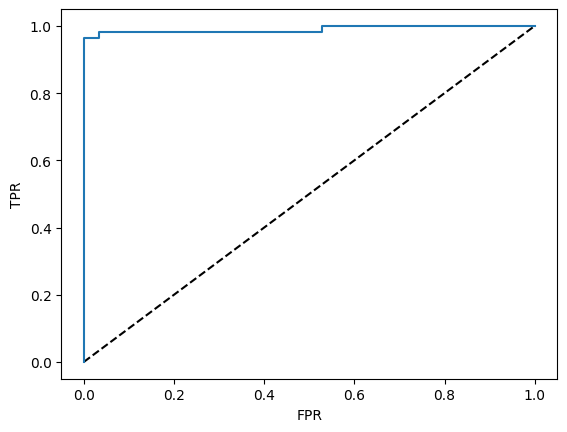

In [30]:
x = tf.range(0, 1.1, 0.1)

plt.plot(x, x, linestyle="--", c="k")

plt.plot(fpr, tpr)
plt.xlabel("FPR")
plt.ylabel("TPR")

Si queremos hacer una evaluación rápida de varios modelos podemos resumir la información de la curva de ROC en un solo número midiendo el área bajo la curva

In [31]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_test, y_pred_test)

0.9897596656217346

## Implementando el modelo en Keras

In [32]:
from tensorflow.keras import layers, Sequential
from tensorflow import keras

In [33]:
model = Sequential(
    [
        layers.Dense(units=1, activation=None)
    ]
)


In [34]:
model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate), 
    
    loss=keras.losses.BinaryCrossentropy(from_logits=True), 

    metrics=[keras.metrics.BinaryAccuracy(threshold=0.5)],
)

In [35]:
history = model.fit(
    train_dataset, 
    epochs=epochs,
    validation_data=test_dataset,
)

Epoch 1/200


2023-07-02 14:20:22.767725: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7feda0002630 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-07-02 14:20:22.767748: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA RTX A5000, Compute Capability 8.6
2023-07-02 14:20:22.921470: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600


7/7 [==============================] - 1s 13ms/step - loss: 0.9839 - binary_accuracy: 0.4333 - val_loss: 0.8421 - val_binary_accuracy: 0.5141
Epoch 2/200
7/7 [==============================] - 0s 2ms/step - loss: 0.7870 - binary_accuracy: 0.6230 - val_loss: 0.6875 - val_binary_accuracy: 0.6549
Epoch 3/200
7/7 [==============================] - 0s 2ms/step - loss: 0.6503 - binary_accuracy: 0.7166 - val_loss: 0.5846 - val_binary_accuracy: 0.7465
Epoch 4/200
7/7 [==============================] - 0s 2ms/step - loss: 0.5574 - binary_accuracy: 0.8009 - val_loss: 0.5150 - val_binary_accuracy: 0.8028
Epoch 5/200
7/7 [==============================] - 0s 2ms/step - loss: 0.4923 - binary_accuracy: 0.8290 - val_loss: 0.4642 - val_binary_accuracy: 0.8662
Epoch 6/200
1/7 [===>..........................] - ETA: 0s - loss: 0.5027 - binary_accuracy: 0.7969

2023-07-02 14:20:23.081912: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


7/7 [==============================] - 0s 2ms/step - loss: 0.4443 - binary_accuracy: 0.8571 - val_loss: 0.4264 - val_binary_accuracy: 0.8803
Epoch 7/200
7/7 [==============================] - 0s 2ms/step - loss: 0.4078 - binary_accuracy: 0.8689 - val_loss: 0.3972 - val_binary_accuracy: 0.8873
Epoch 8/200
7/7 [==============================] - 0s 3ms/step - loss: 0.3797 - binary_accuracy: 0.8876 - val_loss: 0.3739 - val_binary_accuracy: 0.9014
Epoch 9/200
7/7 [==============================] - 0s 2ms/step - loss: 0.3570 - binary_accuracy: 0.8946 - val_loss: 0.3544 - val_binary_accuracy: 0.9085
Epoch 10/200
7/7 [==============================] - 0s 2ms/step - loss: 0.3378 - binary_accuracy: 0.9087 - val_loss: 0.3379 - val_binary_accuracy: 0.9225
Epoch 11/200
7/7 [==============================] - 0s 2ms/step - loss: 0.3219 - binary_accuracy: 0.9087 - val_loss: 0.3238 - val_binary_accuracy: 0.9366
Epoch 12/200
7/7 [==============================] - 0s 2ms/step - loss: 0.3082 - binary_accu

<Axes: >

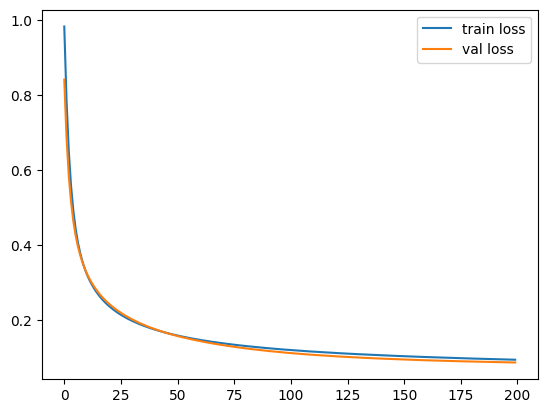

In [36]:
sns.lineplot(x=history.epoch, y=history.history['loss'], label="train loss")
sns.lineplot(x=history.epoch, y=history.history['val_loss'], label="val loss")


<Axes: >

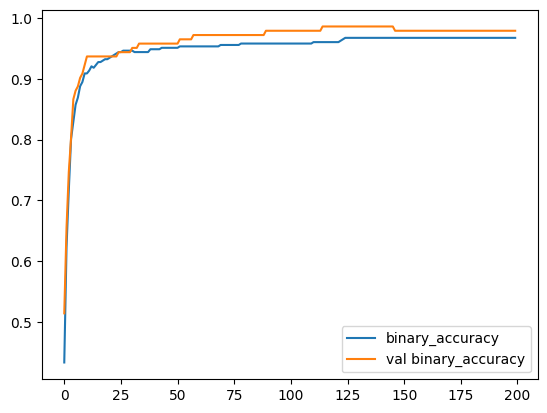

In [37]:
sns.lineplot(x=history.epoch, y=history.history['binary_accuracy'], label="binary_accuracy")
sns.lineplot(x=history.epoch, y=history.history['val_binary_accuracy'], label="val binary_accuracy")
